In [ ]:
import numpy as np
from skimage.draw import line
from scipy.ndimage import label
from scipy.ndimage import convolve
import matplotlib.pyplot as plt


In [15]:
def generate_koch_snowflake(iterations):
    """
    Generate the Koch snowflake as a single closed component.
    Returns:
        components : List[np.ndarray] with one (N, 2) array of vertices.
    """
    angle_offset = np.pi / 6  # rotate to flatten base
    angles = np.array([0, 2*np.pi/3, 4*np.pi/3]) + angle_offset
    vertices = np.stack([np.cos(angles), np.sin(angles)], axis=1)
    vertices = np.vstack([vertices, vertices[0]])  # close triangle

    for _ in range(iterations):
        new_vertices = []
        for i in range(len(vertices) - 1):
            p0 = vertices[i]
            p1 = vertices[i + 1]
            delta = p1 - p0
            one_third = p0 + delta / 3
            two_third = p0 + 2 * delta / 3
            length = np.linalg.norm(delta) / 3
            angle = np.arctan2(delta[1], delta[0]) - np.pi / 3
            peak = np.array([
                one_third[0] + length * np.cos(angle),
                one_third[1] + length * np.sin(angle)
            ])
            new_vertices.extend([p0, one_third, peak, two_third])
        new_vertices.append(vertices[-1])
        vertices = np.array(new_vertices)

    return [vertices]


In [22]:
def rasterize_koch_snowflake(components, target_max_dim=None, padding=0):
    """
    Rasterize a list of vertex arrays into a binary image, with symmetric padding.
    
    Parameters:
        components : List[np.ndarray]
            Each element is a (N, 2) array of vertices.
        target_max_dim : int or None
            Max width/height of the scaled shape (excluding padding).
        padding : int
            Padding added equally to all sides (in pixels).
    
    Returns:
        img : 2D np.ndarray (bool)
            Rasterized image of shape (H + 2*padding, W + 2*padding).
    """
    all_vertices = np.vstack(components)
    min_x, min_y = all_vertices.min(axis=0)
    max_x, max_y = all_vertices.max(axis=0)
    width = max_x - min_x
    height = max_y - min_y

    if target_max_dim is not None:
        scale = target_max_dim / max(width, height)
    else:
        scale = 1.0

    # Shift and scale to top-left origin with no padding
    scaled_components = []
    for comp in components:
        shifted = (comp - [min_x, min_y]) * scale
        snapped = np.round(shifted).astype(np.int32)
        scaled_components.append(snapped)

    # Get shape after scaling (before padding)
    all_snapped = np.vstack(scaled_components)
    shape_w = all_snapped[:, 0].max() + 1
    shape_h = all_snapped[:, 1].max() + 1

    # Final image size with symmetric padding
    img_width = shape_w + 2 * padding
    img_height = shape_h + 2 * padding
    img = np.zeros((img_height, img_width), dtype=bool)

    # Rasterize with offset for symmetric padding
    for snapped in scaled_components:
        padded = snapped + padding
        for i in range(len(padded)):
            p1 = padded[i]
            p2 = padded[(i + 1) % len(padded)]
            rr, cc = line(p1[1], p1[0], p2[1], p2[0])
            rr = np.clip(rr, 0, img_height - 1)
            cc = np.clip(cc, 0, img_width - 1)
            img[rr, cc] = True

    return img

def plot_raster_image(img, title="", figsize=(5,5), cmap='gray'):
    """
    Display a binary raster image.
    
    Parameters:
        img : 2D np.ndarray (bool or int)
            The binary image to display.
        title : str
            Optional title for the plot.
        figsize : tuple
            Size of the matplotlib figure.
        cmap : str
            Colormap to use (default 'gray').
    """
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [34]:
def slice_and_mirror_image(img, fraction, axis='x'):
    """
    Slice and mirror a binary raster image along the given fraction.
    """
    H, W = img.shape
    if axis == 'x':
        slice_col = int(fraction * W)
        left = img[:, :slice_col]
        mirrored = np.fliplr(left)
        stitched = np.concatenate([left, mirrored], axis=1)
    elif axis == 'y':
        slice_row = int(fraction * H)
        top = img[:slice_row, :]
        mirrored = np.flipud(top)
        stitched = np.concatenate([top, mirrored], axis=0)
    else:
        raise ValueError("Axis must be 'x' or 'y'")

    return stitched

In [35]:
def flood_fill(img):
    """
    Fill the interior of a binary shape by labeling connected background regions
    and inverting the outer background.

    Parameters:
        img : 2D np.ndarray (bool)
            Binary image where True represents the boundary.

    Returns:
        filled : 2D np.ndarray (bool)
            Binary image with the interior filled.
    """
    labeled, _ = label(~img)  # label background
    background_label = labeled[0, 0]  # assume (0,0) is outside the shape
    filled = labeled != background_label  # everything not connected to outside is filled
    return filled

In [53]:
def measure_area_perimeter(img):
    """
    Compute area and perimeter via convolution.
    """
    A = np.sum(img)
    kernel = np.array([[1,1,1],
                       [1,0,1],
                       [1,1,1]])
    neighbors = convolve(img.astype(np.uint8), kernel, mode='constant', cval=0)
    perimeter_pixels = ((img == 1) & (neighbors < 8))
    P = np.sum(perimeter_pixels)
    return A, P

In [60]:
import os
import time
import matplotlib.pyplot as plt

def save_pixel_perfect_image(img, out_dir="out", prefix="koch", cmap="gray"):
    """
    Save a binary image as a pixel-perfect PNG with exact pixel resolution.
    
    Parameters:
        img : 2D np.ndarray (bool or int)
            The binary image to save.
        out_dir : str
            Directory to save the PNG file.
        prefix : str
            Prefix for the filename (e.g., "koch").
        cmap : str
            Colormap to use (default 'gray').
    
    Returns:
        str : Full path to the saved image.
    """
    H, W = img.shape
    os.makedirs(out_dir, exist_ok=True)
    
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    unique_name = f"{prefix}_{timestamp}.png"
    full_path = os.path.join(out_dir, unique_name)

    # Create a figure with no margin or axes
    dpi = 100  # This will be overridden
    fig = plt.figure(figsize=(W / dpi, H / dpi), dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1])  # fill entire figure
    ax.imshow(img, cmap=cmap, interpolation='none')
    ax.axis('off')
    
    fig.savefig(full_path, dpi=dpi, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

    return full_path


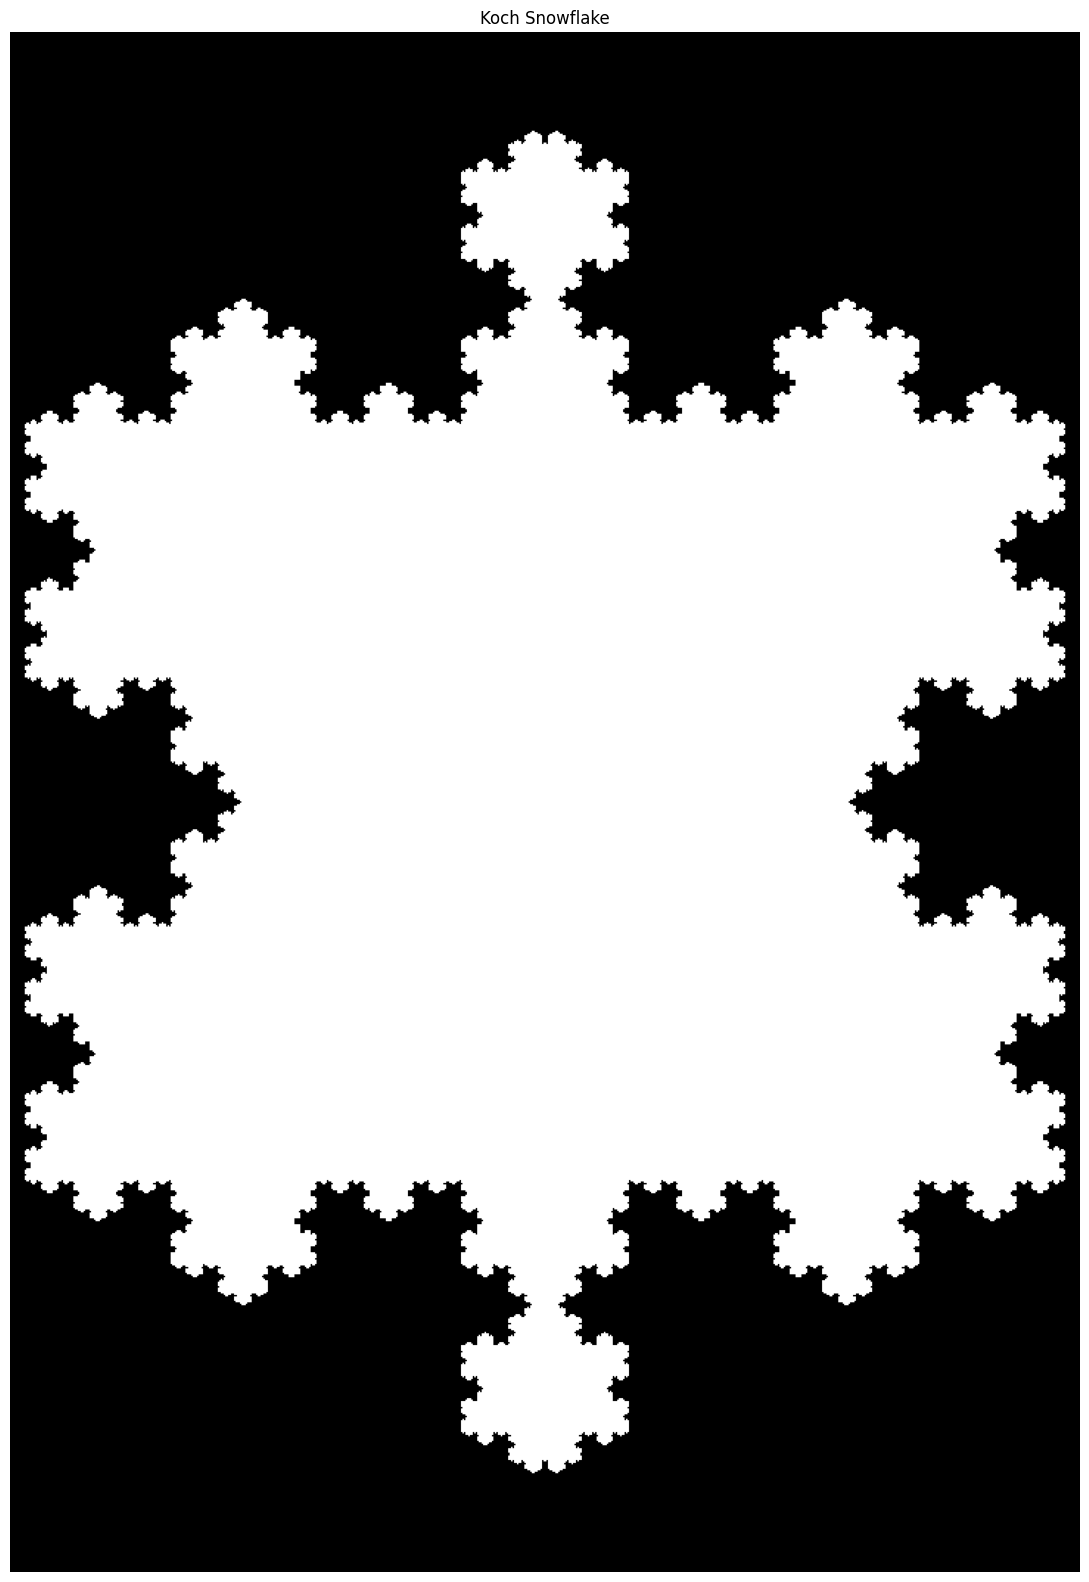

In [64]:
components = generate_koch_snowflake(iterations=7)
img = rasterize_koch_snowflake(components, target_max_dim=1024, padding=10)
img = flood_fill(img)

img = slice_and_mirror_image(img, fraction=0.4)

plot_raster_image(img, title="Koch Snowflake", figsize=(20,20))

# save_pixel_perfect_image(img)